In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import dash
import dash_core_components as dcc
import dash_html_components as html

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html

import plotly.graph_objects as go

from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.keras import BalancedBatchGenerator

C:\Users\kroep\AppData\Local\Temp\ipykernel_14272\143537176.py:24: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\kroep\AppData\Local\Temp\ipykernel_14272\143537176.py:25: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

#### Load Data

In [3]:
df = pd.read_csv('data\\water_potability.csv')

print(f'df.shape: {df.shape}')

df.head()

df.shape: (3276, 10)


ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

#### Fill Nan values

In [4]:
print(f'NaN values (before):\n{df.isnull().sum()}\n')

NaN values (before):
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64



In [5]:
def plot_columns(df: pd.DataFrame):
    """
    This function generates histograms for each column in the specified DataFrame.
    """
    
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    
    row_idx = 0
    col_idx = 0

    for column in df.columns:
        sns.histplot(data=df, x=column, kde=True, ax=axs[row_idx][col_idx])
        axs[row_idx][col_idx].axvline(df[column].mean(), color='r', linestyle='--')

        # update position of next plot
        col_idx += 1
        if col_idx > 4:
            row_idx += 1
            col_idx = 0

    plt.suptitle('Histograms of columns with mean', fontsize=24)
    plt.tight_layout()
    plt.show()

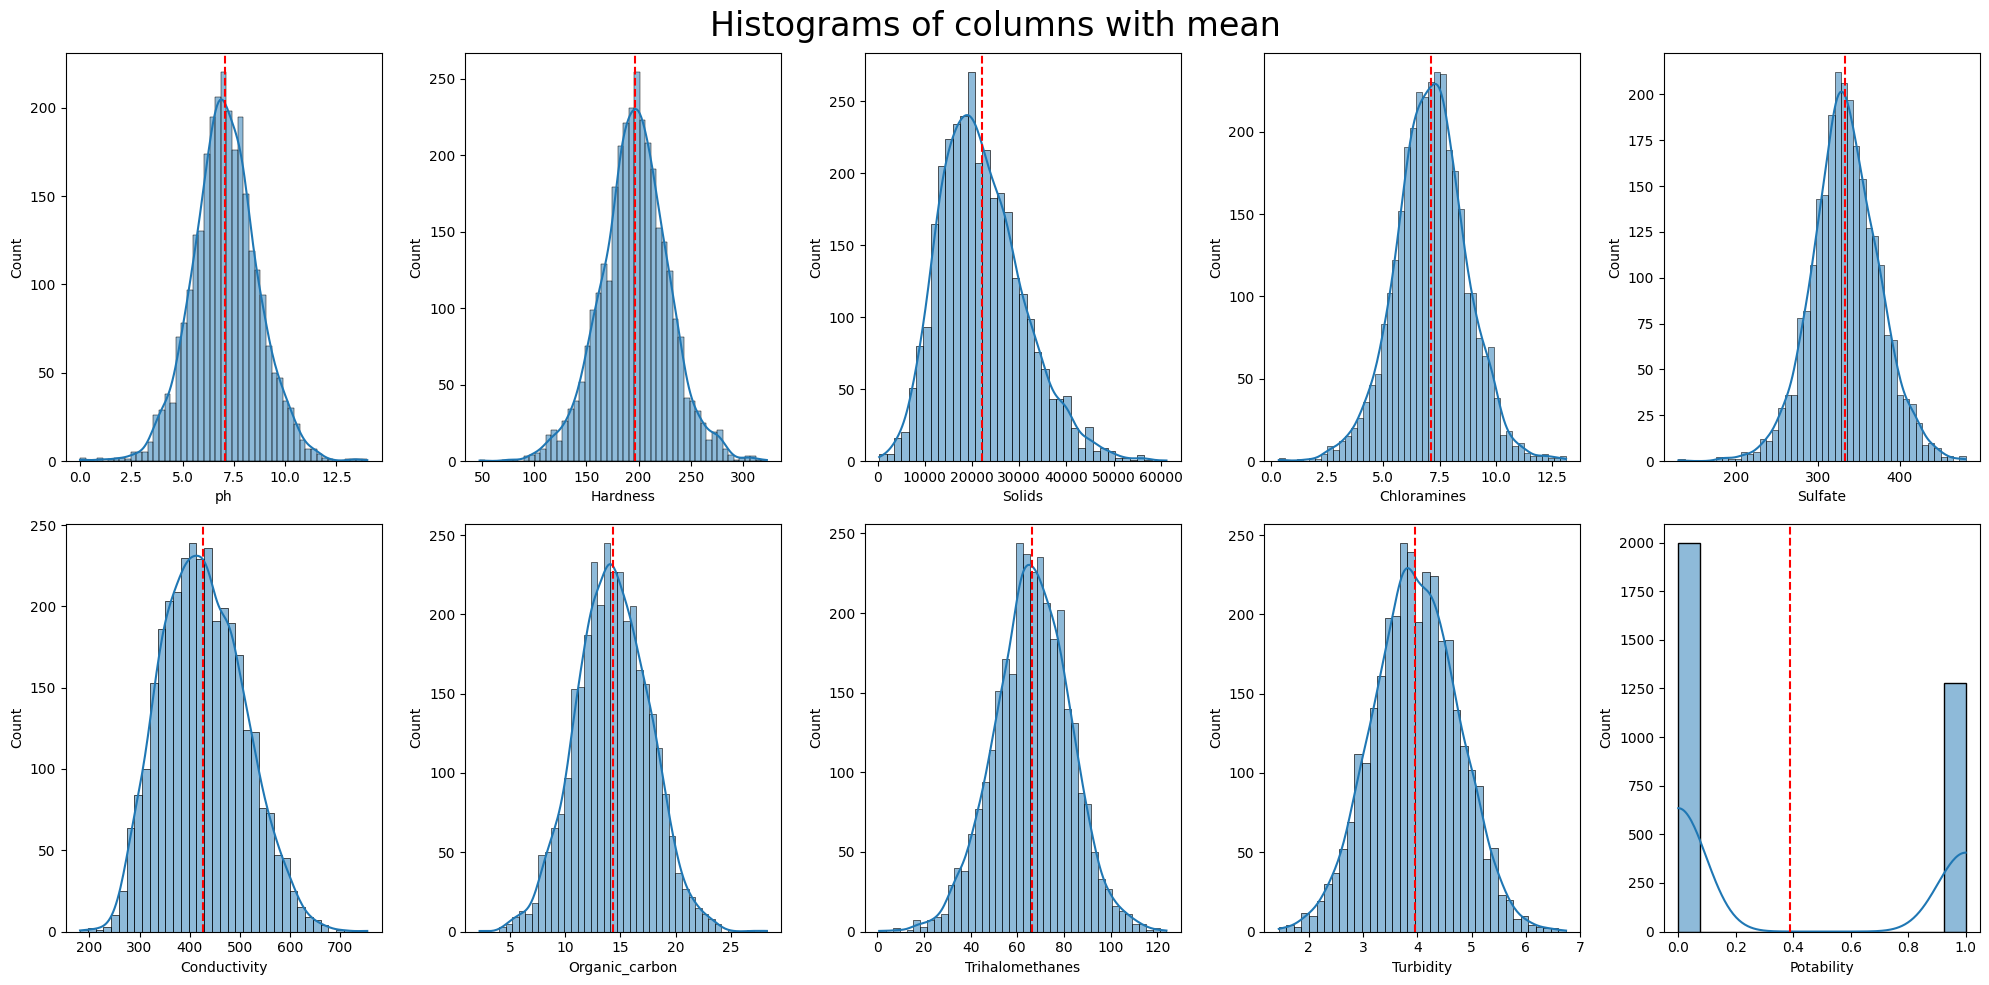

In [6]:
plot_columns(df)

We can see, that the values for which there are missing values are normally distributed, so we can replace them with the mean of the column.

In [7]:
df = df.fillna(df.mean())
print(f'NaN values (after):\n{df.isnull().sum()}')

NaN values (after):
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


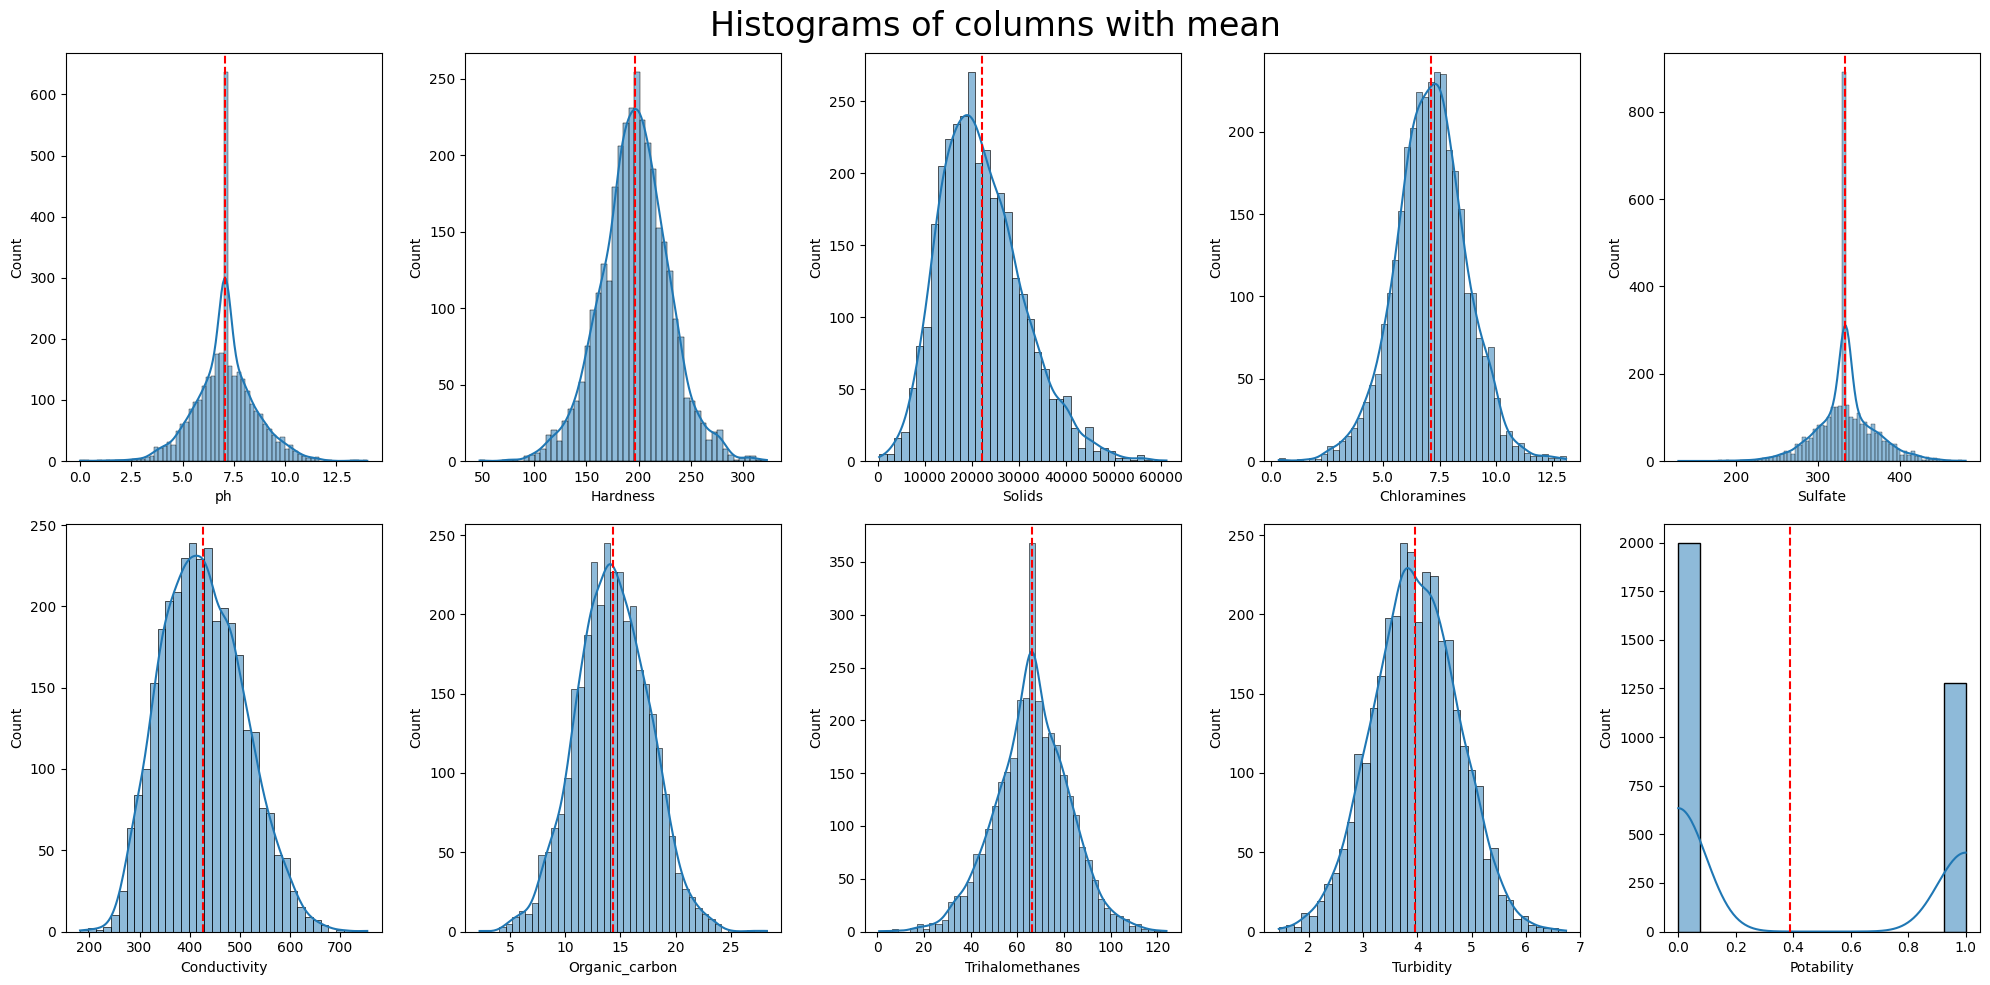

In [8]:
plot_columns(df)

#### Exploratory Data Analysis

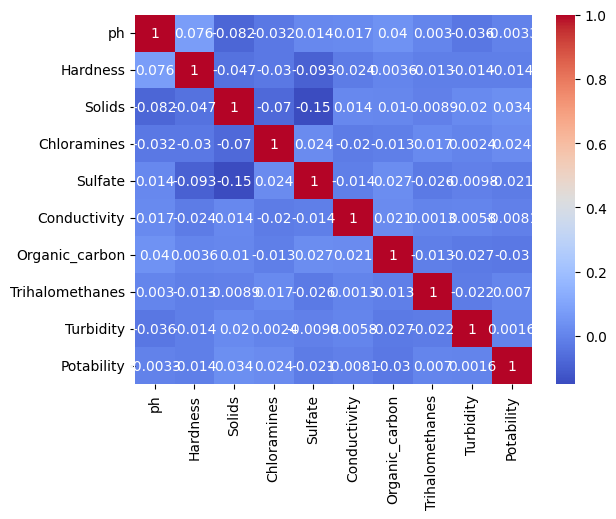

In [9]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

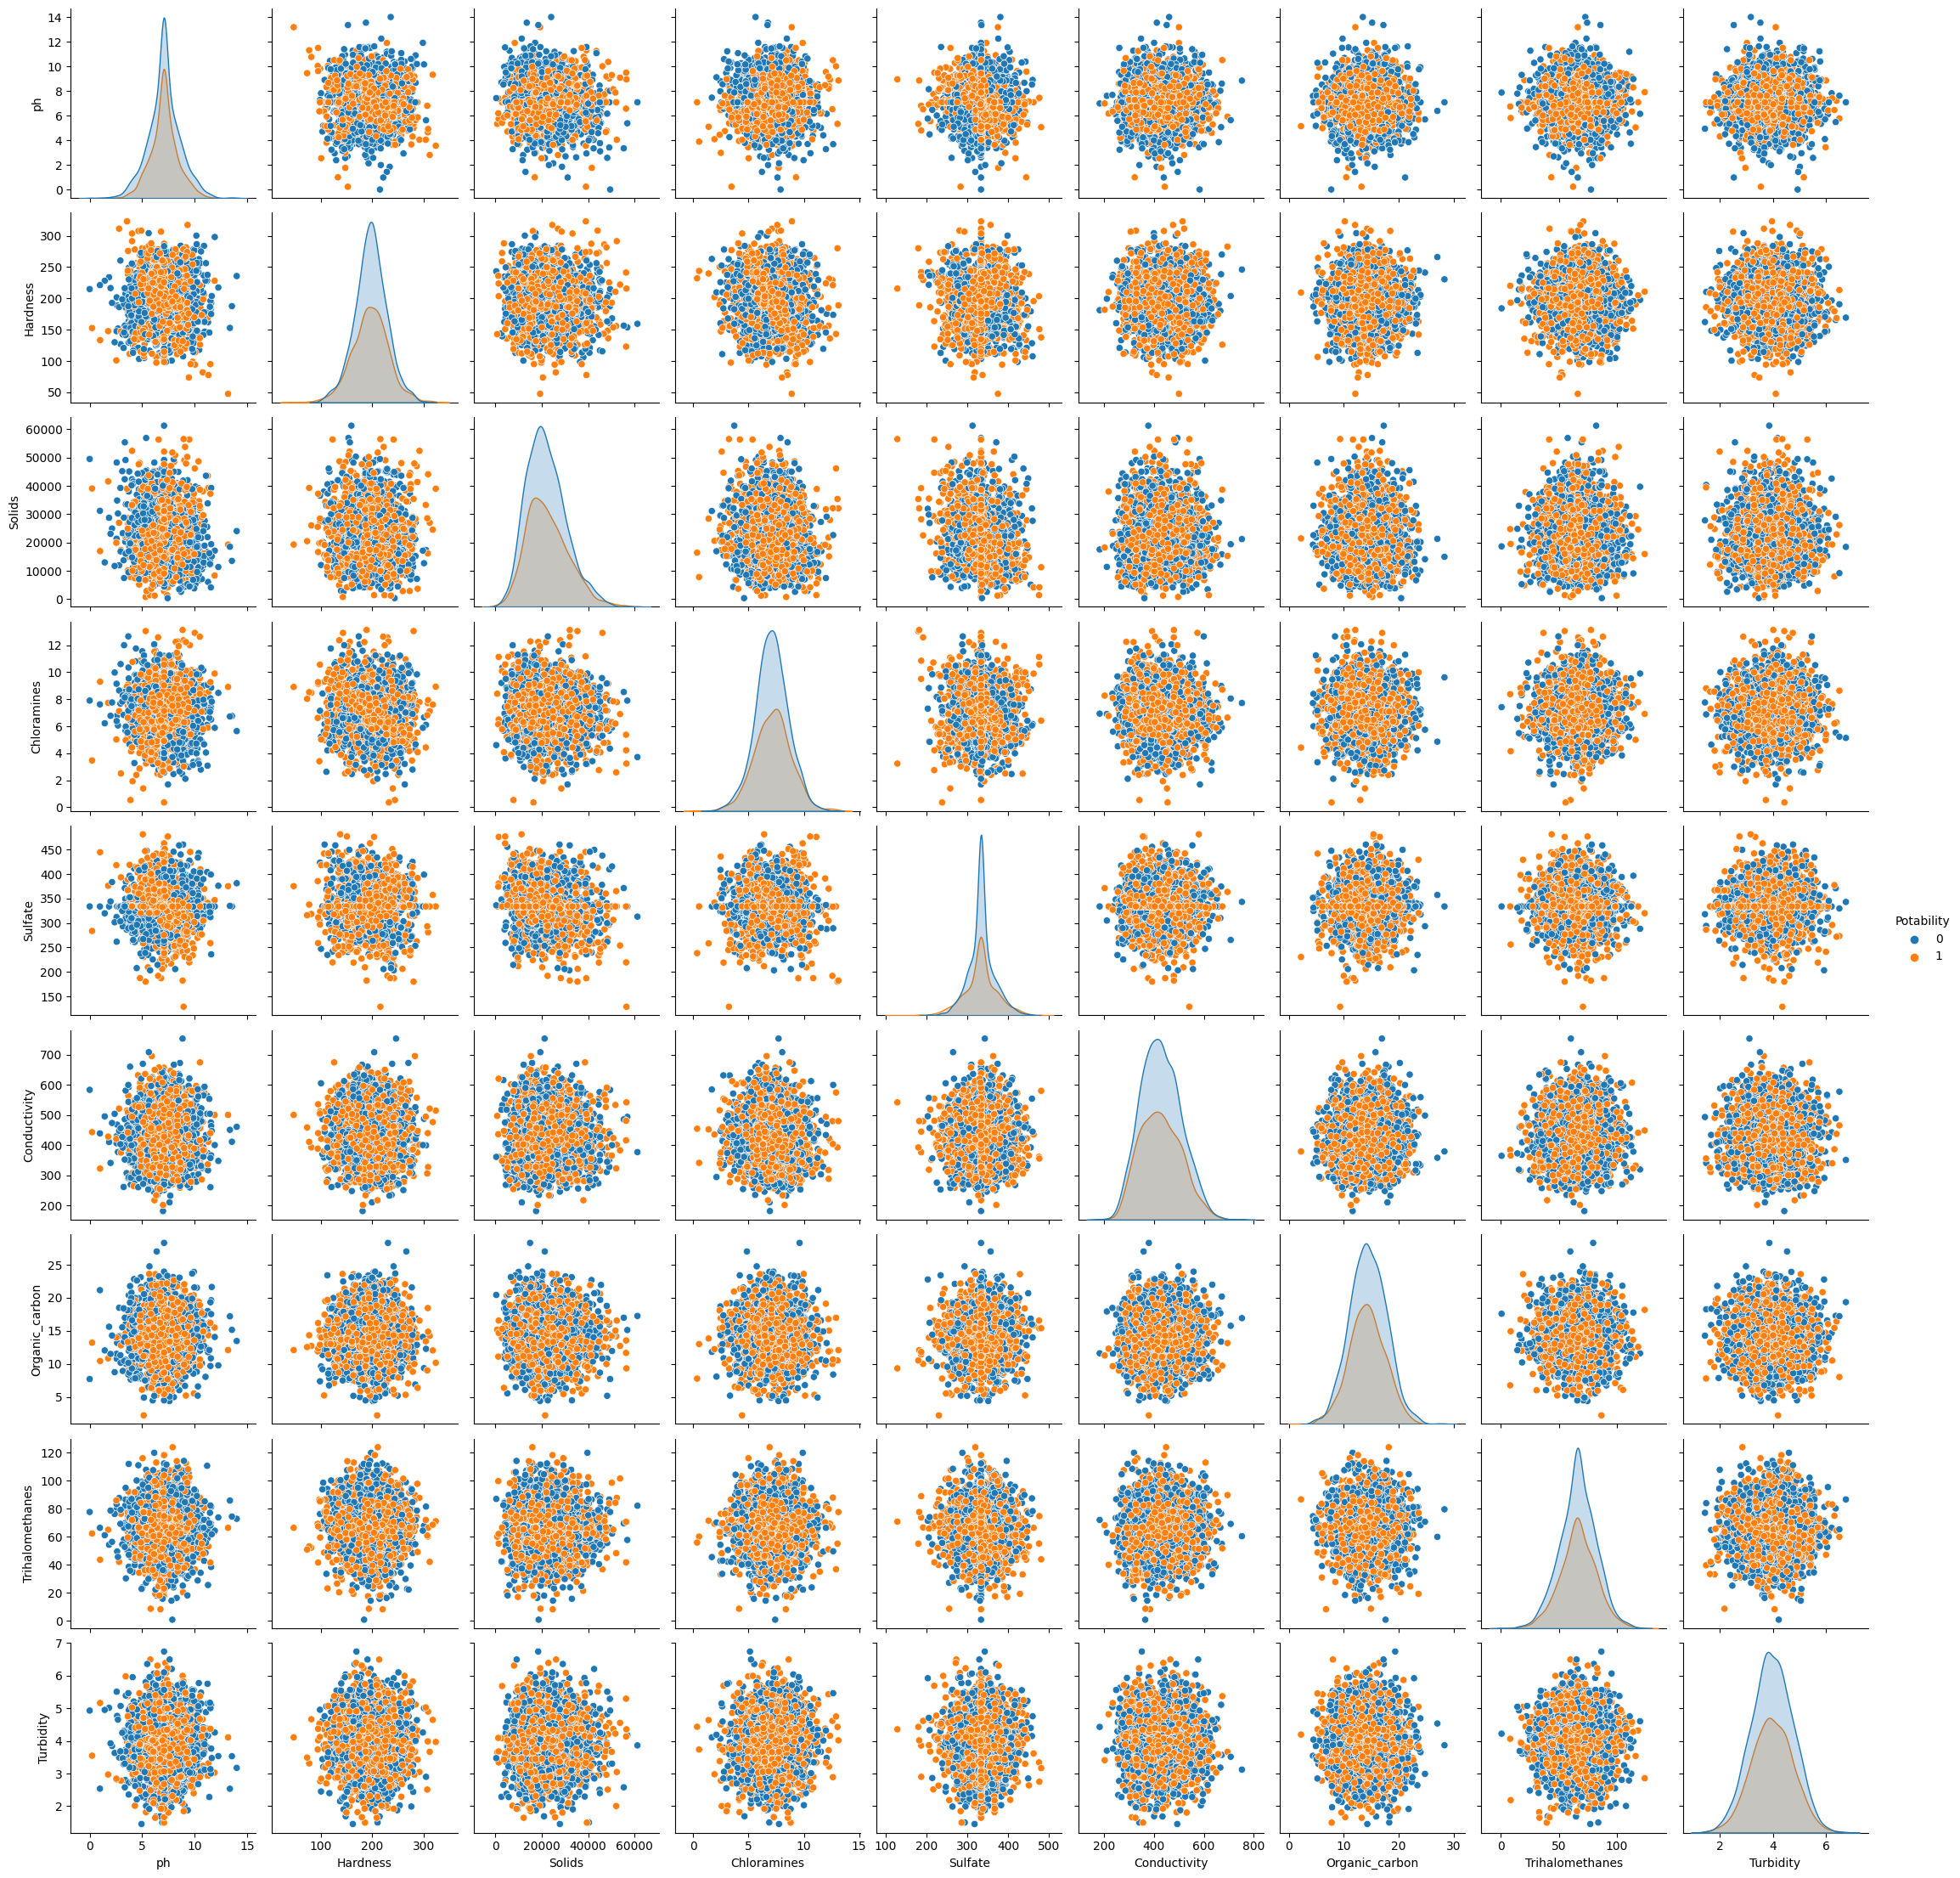

In [10]:
sns.pairplot(df, hue='Potability')
plt.show()

#### Make Classifiers

In [11]:
# define data
X = df.drop('Potability', axis=1)
y = df['Potability']

# make train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# feature normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def create_model(optimizer='adam', neurons=100, n_hidden=3):
    # make model and add input layer
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    
    # add hidden layers
    for _ in range(n_hidden):  
        model.add(Dense(neurons, activation='relu'))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile it
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


fnn = KerasClassifier(build_fn=create_model, verbose=0)

classifiers = {
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [9, 15, 21, 24],
            "algorithm": ["auto"]#, "ball_tree", "kd_tree", "brute"]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [200, 300, 400, 500],
            "criterion": ["entropy"],
            "max_depth": [None]
        }
    },
    "LGBMClassifier": {
        "model": LGBMClassifier(),
        "params": {
            "n_estimators": [30, 40, 50], #, 100, 150],
            "learning_rate": [0.001, 0.05, 0.01, 0.1],
            "max_depth": [-1]#, 10, 20]
        }
    },
    "XGBClassifier": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.001, 0.01, 0.1],
            "max_depth": [3, 6, 9]
        }
    },
    "FNN": {
        "model": fnn,
        "params": {
            "epochs": [100],
            "batch_size": [128],
            "optimizer": ['SGD'],
            "neurons": [100],
            "n_hidden": [3]
        }
    }
}

C:\Users\kroep\AppData\Local\Temp\ipykernel_14272\1691316487.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  fnn = KerasClassifier(build_fn=create_model, verbose=0)


#### Grid Search

In [12]:
def make_grid_search(classifiers, X_train, y_train, X_test, y_test):
    """
    This function performs a grid search to determine the optimal hyperparameters for each classifier
    in the classifiers dictionary by doing 5-fold cross-validation with accuracy as metric.

    Args:
        classifiers (dict): A dictionary where keys are names of classifiers and values are dictionaries 
                            containing two keys - 'model', which is an instance of a classifier, and 'params',
                            which is a dictionary of parameters to be tested in the grid search.
        X_train (pd.DataFrame): The training data.
        y_train (pd.Series): The target variable for the training data.
        X_test (pd.DataFrame): The testing data.
        y_test (pd.Series): The actual target variable for the testing data.
        y_pred (pd.Series): The predicted target variable for the testing data.

    Returns:
        None, only print statements.
    """
    
    model_acc_dict = dict()
    
    for clf_name, clf in classifiers.items():
        print(f'{clf_name}:')

        # grid search to find best hyperparameter setting
        gs = GridSearchCV(clf["model"], clf["params"], cv=5, scoring='accuracy')
        gs.fit(X_train, y_train)
        
        y_pred = gs.best_estimator_.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"  accuracy: {round(acc, 5)}, best params: {gs.best_params_}")
        
        model_acc_dict[clf_name] = {
            "model": gs,
            "acc": acc
        }
    
    return model_acc_dict

In [13]:
model_acc = make_grid_search(classifiers, X_train, y_train, X_test, y_test)

SVC:
  accuracy: 0.69512, best params: {'C': 1, 'kernel': 'rbf'}
KNeighborsClassifier:
  accuracy: 0.66159, best params: {'algorithm': 'auto', 'n_neighbors': 15}
RandomForestClassifier:
  accuracy: 0.6936, best params: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500}
LGBMClassifier:
  accuracy: 0.6753, best params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 40}
XGBClassifier:
  accuracy: 0.66616, best params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
FNN:
21/21 [==============================] - 0s 1000us/step
  accuracy: 0.6753, best params: {'batch_size': 128, 'epochs': 100, 'n_hidden': 3, 'neurons': 100, 'optimizer': 'SGD'}


In [14]:
# model_acc['SVC']['acc']

In [15]:
# model_acc['SVC']['model'].best_estimator_.feature_importances_

#### Feature Engineering

In [16]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

df_poly = poly_features.fit_transform(X)

# get feature names
feature_names = poly_features.get_feature_names_out(input_features=X.columns)

# create new df with polynomial features
df_poly = pd.DataFrame(df_poly, columns=feature_names)

In [17]:
df_poly.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'ph^2', 'ph Hardness',
       'ph Solids', 'ph Chloramines', 'ph Sulfate', 'ph Conductivity',
       'ph Organic_carbon', 'ph Trihalomethanes', 'ph Turbidity', 'Hardness^2',
       'Hardness Solids', 'Hardness Chloramines', 'Hardness Sulfate',
       'Hardness Conductivity', 'Hardness Organic_carbon',
       'Hardness Trihalomethanes', 'Hardness Turbidity', 'Solids^2',
       'Solids Chloramines', 'Solids Sulfate', 'Solids Conductivity',
       'Solids Organic_carbon', 'Solids Trihalomethanes', 'Solids Turbidity',
       'Chloramines^2', 'Chloramines Sulfate', 'Chloramines Conductivity',
       'Chloramines Organic_carbon', 'Chloramines Trihalomethanes',
       'Chloramines Turbidity', 'Sulfate^2', 'Sulfate Conductivity',
       'Sulfate Organic_carbon', 'Sulfate Trihalomethanes',
       'Sulfate Turbidity', 'Conductivity^2', 'Conductivity Organic_carbon

#### Again, train models

In [18]:
df_poly['Potability'] = y

X_poly = df_poly.drop('Potability', axis=1)
y_poly = df_poly['Potability']

# make train and test splits
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# feature normalization
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

def create_model(optimizer='adam', neurons=100, n_hidden=3):
    # make model and add input layer
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_poly.shape[1], activation='relu'))
    
    # add hidden layers
    for _ in range(n_hidden):  
        model.add(Dense(neurons, activation='relu'))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

fnn = KerasClassifier(build_fn=create_model, verbose=0)

# here we only have to update fnn, because the input dimension changes
classifiers["FNN"] = {
    "model": fnn,
    "params": {
        "epochs": [100],
        "batch_size": [128],
        "optimizer": ['SGD'],
        "neurons": [100],
        "n_hidden": [3]
    }
}

C:\Users\kroep\AppData\Local\Temp\ipykernel_14272\1539223529.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  fnn = KerasClassifier(build_fn=create_model, verbose=0)


In [19]:
model_acc_poly = make_grid_search(classifiers, X_train_poly, y_train_poly, X_test_poly, y_test_poly)

SVC:
  accuracy: 0.67378, best params: {'C': 10, 'kernel': 'linear'}
KNeighborsClassifier:
  accuracy: 0.65549, best params: {'algorithm': 'auto', 'n_neighbors': 24}
RandomForestClassifier:
  accuracy: 0.69512, best params: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 400}
LGBMClassifier:
  accuracy: 0.6875, best params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 40}
XGBClassifier:
  accuracy: 0.67378, best params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 150}
FNN:
21/21 [==============================] - 0s 999us/step
  accuracy: 0.66768, best params: {'batch_size': 128, 'epochs': 100, 'n_hidden': 3, 'neurons': 100, 'optimizer': 'SGD'}


In [20]:
model_acc_poly['RandomForestClassifier']['model'].best_estimator_.feature_importances_

array([0.02101262, 0.02103249, 0.01633803, 0.01783089, 0.02591129,
       0.01551758, 0.0156783 , 0.01454591, 0.01523613, 0.02128304,
       0.02345372, 0.0205051 , 0.02369842, 0.02840639, 0.0197192 ,
       0.01698784, 0.01860321, 0.01771933, 0.02064947, 0.01969104,
       0.01963078, 0.0309084 , 0.01818964, 0.01761316, 0.0174691 ,
       0.01808026, 0.01532456, 0.01900512, 0.01698905, 0.01715839,
       0.01676228, 0.01896382, 0.01722599, 0.01783517, 0.02210186,
       0.01725805, 0.01708743, 0.01801971, 0.01869807, 0.02478228,
       0.01828014, 0.01752883, 0.0164666 , 0.01655235, 0.01599321,
       0.0158342 , 0.01751405, 0.01590359, 0.01559154, 0.01634487,
       0.01580841, 0.01473459, 0.01602001, 0.01450448])

In [21]:
df_poly.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'ph^2', 'ph Hardness',
       'ph Solids', 'ph Chloramines', 'ph Sulfate', 'ph Conductivity',
       'ph Organic_carbon', 'ph Trihalomethanes', 'ph Turbidity', 'Hardness^2',
       'Hardness Solids', 'Hardness Chloramines', 'Hardness Sulfate',
       'Hardness Conductivity', 'Hardness Organic_carbon',
       'Hardness Trihalomethanes', 'Hardness Turbidity', 'Solids^2',
       'Solids Chloramines', 'Solids Sulfate', 'Solids Conductivity',
       'Solids Organic_carbon', 'Solids Trihalomethanes', 'Solids Turbidity',
       'Chloramines^2', 'Chloramines Sulfate', 'Chloramines Conductivity',
       'Chloramines Organic_carbon', 'Chloramines Trihalomethanes',
       'Chloramines Turbidity', 'Sulfate^2', 'Sulfate Conductivity',
       'Sulfate Organic_carbon', 'Sulfate Trihalomethanes',
       'Sulfate Turbidity', 'Conductivity^2', 'Conductivity Organic_carbon

#### Interactive Dashbord

In [22]:
# make df with feature importance
df_importance = pd.DataFrame()
df_importance['feature'] = df_poly.columns.drop('Potability')
df_importance['importance_value'] = model_acc_poly['RandomForestClassifier']['model'].best_estimator_.feature_importances_

# sort it for a nicer plot
df_importance = df_importance.sort_values('importance_value', ascending=False)
df_importance = df_importance.reset_index(drop=False, inplace=False)

In [23]:
app = JupyterDash(__name__)

# Create the figure
fig = go.Figure(data=[
    go.Bar(
        x=df_importance['feature'],
        y=df_importance['importance_value'], 
        name='Importance'
    )
])

fig.update_layout(
    title='Feature Importance',
    xaxis={
        'automargin': True,
        'tickangle': 45,
    },
)

# Create the layout
app.layout = html.Div([
    dcc.Graph(
        id='feature-importance',
        figure=fig
    )
])

# Display the figure
fig.show()

In [24]:
# Creating the bar traces
model_names = list(model_acc.keys())
model_names_poly = list(model_acc_poly.keys())
model_acc_list = [model_acc[n]['acc'] for n in model_acc.keys()]
model_acc_list_poly = [model_acc_poly[n]['acc'] for n in model_acc_poly.keys()]

trace1 = go.Bar(x=model_names, y=model_acc_list,
                name='Models (original) ', marker_color='rgb(55, 83, 109)')
trace2 = go.Bar(x=model_names_poly, y=model_acc_list_poly,
                name='Model with PolynomialFeatures', marker_color='rgb(26, 118, 255)')

# max acc line
max_accuracy = max(max(model_acc_list), max(model_acc_list_poly))
trace3 = go.Scatter(x=model_names + model_names_poly, y=[max_accuracy] * (
    len(model_acc_list) + len(model_acc_list_poly)), mode='lines', name='Max accuracy', line=dict(dash='dash'))

data = [trace1, trace2, trace3]

layout = go.Layout(
    title='Accuracy comparison of different models',
    yaxis=dict(title='Accuracy'),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
fig.show()